# Time Series Introduction (Business day data)

This demonstrates how to process time series data with business day frequency.

Business day means weekdays (M-F).

Business days can have missing dates due to public holidays, and Time Series
methods like ARMA/ARIMA can fail because they cannot determine the time 
frequency from the missing dates.

```
(mldds03) pip install statsmodels
```

In [3]:
import statsmodels

statsmodels.__version__

'0.9.0'

## Plots

1. Decomposition plot
2. Lag plot
3. Autocorrelation plot

https://data.gov.sg/dataset/hdb-resale-price-index

In [34]:
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose

df = pd.read_csv('D05.SI.csv',
                 parse_dates=True, index_col=0)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-09-13,16.500000,16.530001,16.340000,16.34,13.719846,3450000
2013-09-16,16.510000,16.580000,16.450001,16.51,13.862587,4065000
2013-09-17,16.510000,16.580000,16.459999,16.48,13.837398,4307000
2013-09-18,16.480000,16.580000,16.389999,16.57,13.912964,3995000
2013-09-19,16.860001,16.950001,16.650000,16.65,13.980135,5390000


In [5]:
df.index

DatetimeIndex(['2013-09-13', '2013-09-16', '2013-09-17', '2013-09-18',
               '2013-09-19', '2013-09-20', '2013-09-23', '2013-09-24',
               '2013-09-25', '2013-09-26',
               ...
               '2018-08-30', '2018-08-31', '2018-09-03', '2018-09-04',
               '2018-09-05', '2018-09-06', '2018-09-07', '2018-09-10',
               '2018-09-11', '2018-09-12'],
              dtype='datetime64[ns]', name='Date', length=1253, freq=None)

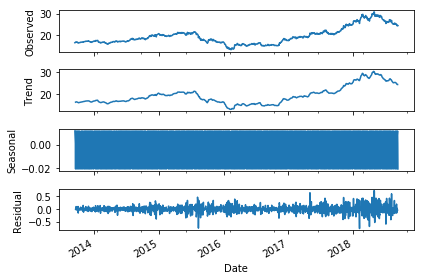

In [6]:
X = df['Close']

# freq values
# https://github.com/statsmodels/statsmodels/blob/master/statsmodels/tsa/tsatools.py#L755
# https://pandas.pydata.org/pandas-docs/stable/timeseries.html#timeseries-offset-aliases

# Annual: freq = 1
# Quarterly: freq = 4
# Monthly: freq = 12
# Weekly: freq = 52
# Daily (7 days a week): freq = 7
# Business Daily (5 days a week): freq = 5
# Hourly: freq = 24

additive = seasonal_decompose(X, model='additive', freq=5) # 5 - business day frequency
additive.plot()
plt.show()

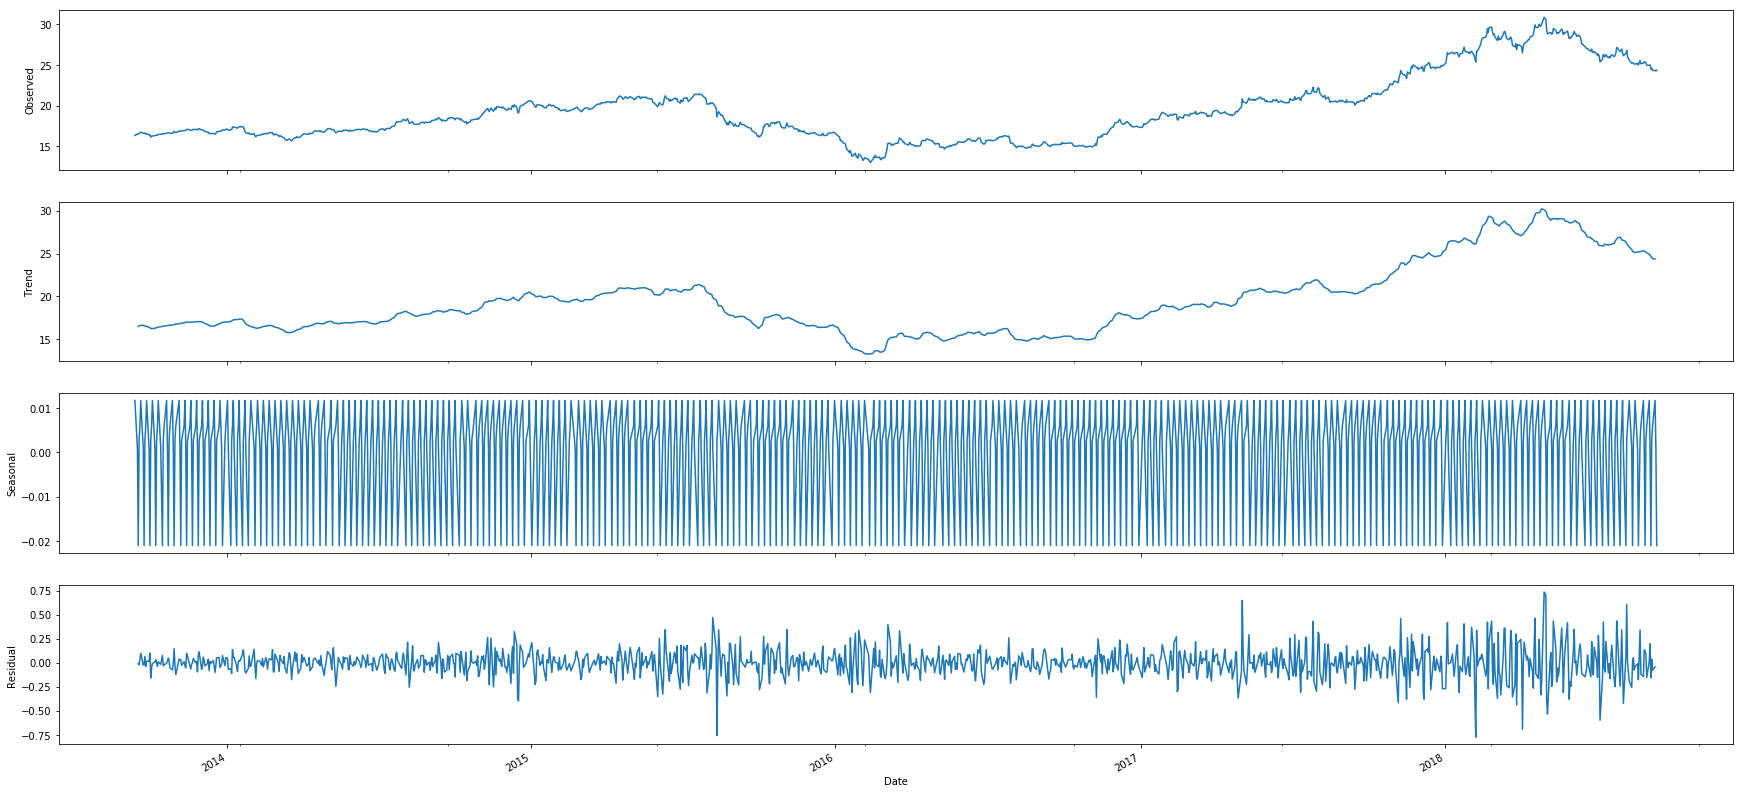

In [7]:
# bigger plot
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(30, 15))

additive.observed.plot(ax=axes[0], legend=False)
axes[0].set_ylabel('Observed')

additive.trend.plot(ax=axes[1], legend=False)
axes[1].set_ylabel('Trend')

additive.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')

additive.resid.plot(ax=axes[3], legend=False)
axes[3].set_ylabel('Residual')

plt.show()

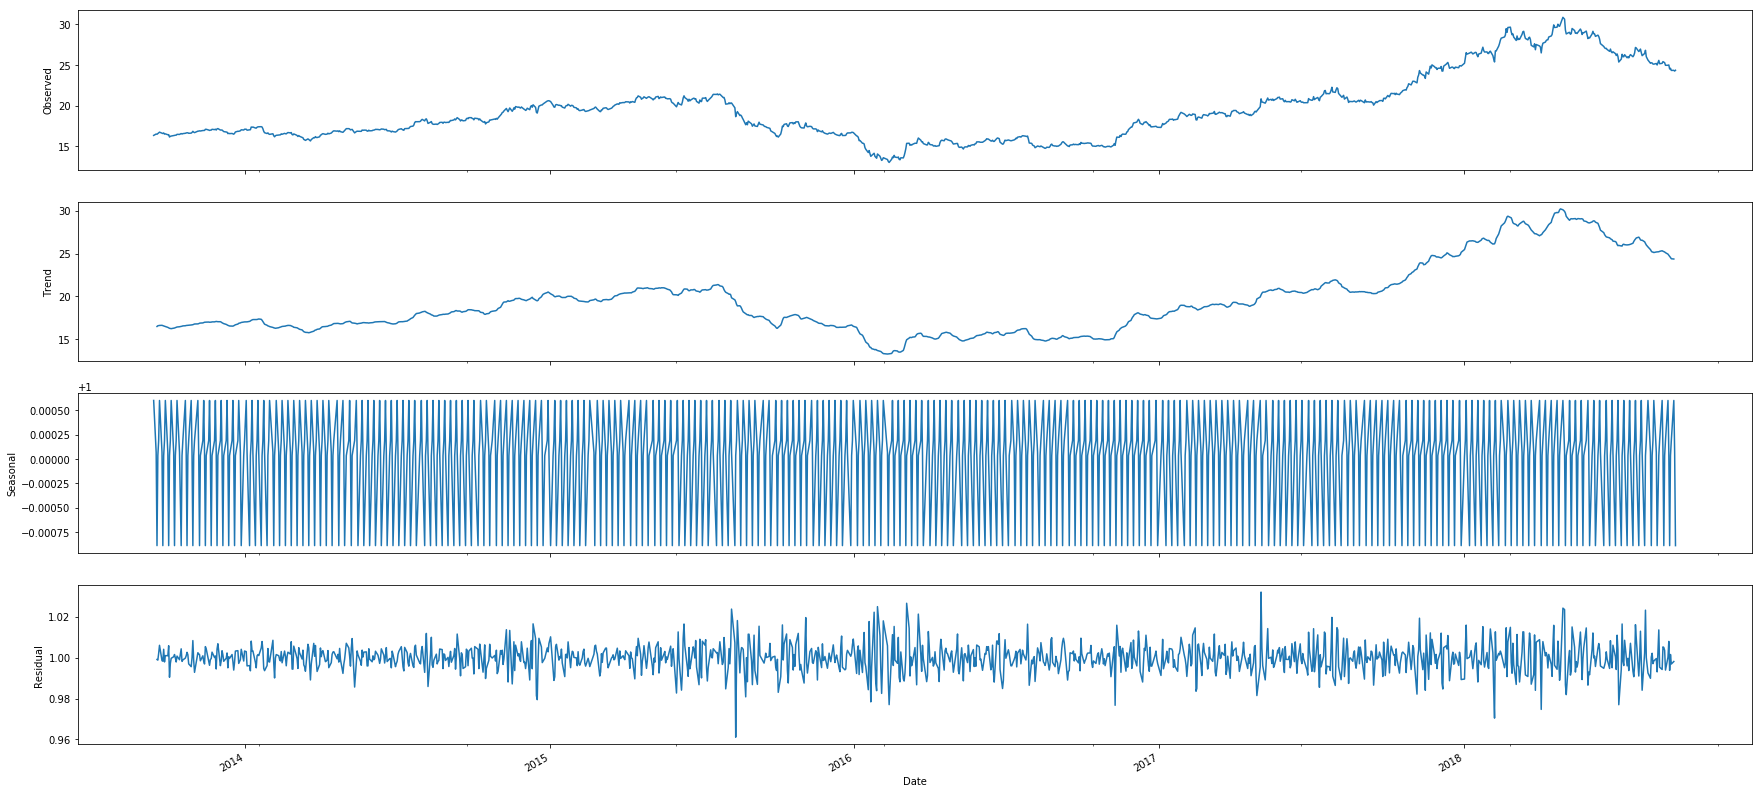

In [8]:
mult = seasonal_decompose(X, model='multiplicative', freq=5) # Observed = Trend * Seasonal * Residual

# mult.plot() # cannot resize :(

# https://github.com/statsmodels/statsmodels/blob/master/statsmodels/tsa/seasonal.py#L176
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(30, 15))

mult.observed.plot(ax=axes[0], legend=False)
axes[0].set_ylabel('Observed')

mult.trend.plot(ax=axes[1], legend=False)
axes[1].set_ylabel('Trend')

mult.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')

mult.resid.plot(ax=axes[3], legend=False)
axes[3].set_ylabel('Residual')

plt.show()

## Implementation Notes for `seasonal_decompose`
    
- Trend: Convolutional filter to compute moving average of Observed. (http://matlabtricks.com/post-11/moving-average-by-convolution)

- Seasonal: compute seasonal mean (Quarterly -> 4 means: one for Q1, Q2, Q3, Q4). Return the means for each quarter across time period.

- Residual: subtract (or divide out) the Trend and Seasonal from Observed.

Details: https://github.com/statsmodels/statsmodels/blob/master/statsmodels/tsa/seasonal.py#L53

### Pseudo-code explanation
```
mult.trend = convolution(mult.observed, filter_moving_average)

detrended = mult.observed - mult.trend

seasonal_mean(detrended) # [seasonal_mean_q1, seasonal_mean_q2, seasonal_mean_q3, seasonal_mean_q4]

# for every Q1 date => seasonal_mean_q1
# ...
mult.seasonal = np.tile(period_averages.T, nobs // freq + 1).T[:nobs]

mult.resid = detrended - mult.seasonal #  mult.observed - mult.trend - mult.seasonal
```

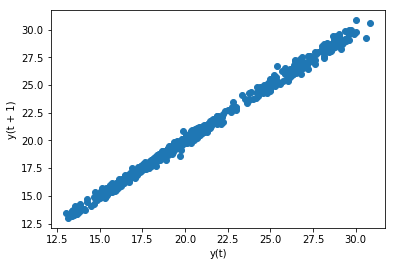

In [9]:
# Lag plot
from pandas.plotting import lag_plot

lag_plot(X)

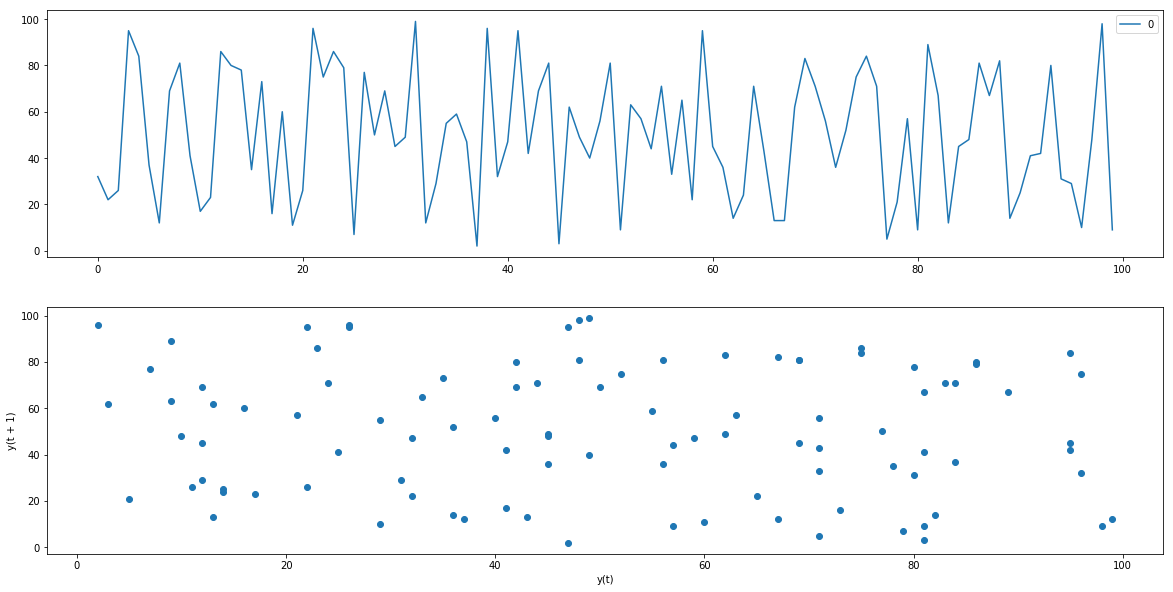

In [10]:
# generate a random series
import numpy as np
random_df = pd.DataFrame(np.random.randint(0, 100, size=(100, 1)))

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(20,10))
random_df.plot(ax=ax1) # series plot
pd.plotting.lag_plot(random_df, ax=ax2) # lag plot (shows no correlation!)

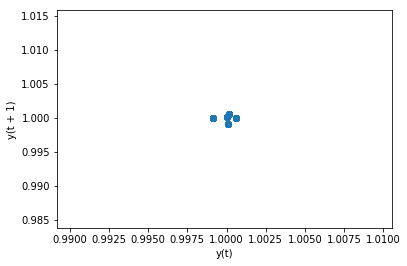

In [11]:
# lag plot of:

lag_plot(mult.seasonal)

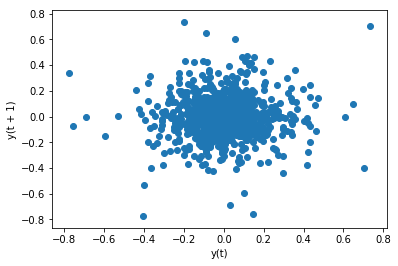

In [12]:
lag_plot(additive.resid)

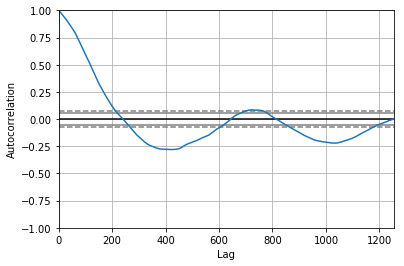

In [13]:
# Auto correlation

from pandas.plotting import autocorrelation_plot

autocorrelation_plot(X)

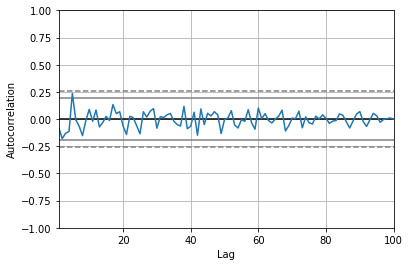

In [14]:
autocorrelation_plot(random_df)

In [15]:
# Example of how to get the correlation values programmatically

# Alternative to calling .autocorr in a loop with different lag value
# https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.autocorr.html

def get_auto_correlation(series):
    from pandas.compat import range, lmap
    import numpy as np
    
    # https://github.com/pandas-dev/pandas/blob/master/pandas/plotting/_misc.py
    n = len(series)
    data = np.asarray(series)
    mean = np.mean(data)
    c0 = np.sum((data - mean) ** 2) / float(n)

    def r(h):
        return ((data[:n - h] - mean) *
                    (data[h:] - mean)).sum() / float(n) / c0
    x = np.arange(n) + 1
    y = lmap(r, x)
    return x, y

lag, correlations = get_auto_correlation(df)
for l, corr in zip(lag, correlations):
    print('Lag', l, 'Correlation', corr)

Lag 1 Correlation 0.8857297712194783
Lag 2 Correlation 0.8342500438352343
Lag 3 Correlation 0.8267193775602879
Lag 4 Correlation 0.8215704122637113
Lag 5 Correlation 0.8136143418429852
Lag 6 Correlation 0.8117642201099854
Lag 7 Correlation 0.8100430350316081
Lag 8 Correlation 0.8019703556537863
Lag 9 Correlation 0.79723893891684
Lag 10 Correlation 0.7961884763668319
Lag 11 Correlation 0.7793693128601689
Lag 12 Correlation 0.7747801234198691
Lag 13 Correlation 0.7777754039703214
Lag 14 Correlation 0.7767705538271098
Lag 15 Correlation 0.7664747030845578
Lag 16 Correlation 0.7560937852458283
Lag 17 Correlation 0.7602702579512347
Lag 18 Correlation 0.7634755683079694
Lag 19 Correlation 0.7680802798241476
Lag 20 Correlation 0.7712848708406309
Lag 21 Correlation 0.7668136700246859
Lag 22 Correlation 0.7559045716751189
Lag 23 Correlation 0.7538060177333749
Lag 24 Correlation 0.7605377821884558
Lag 25 Correlation 0.7624211888308415
Lag 26 Correlation 0.7550953520492734
Lag 27 Correlation 0.74

Lag 216 Correlation 0.6251257071212796
Lag 217 Correlation 0.6268004865380816
Lag 218 Correlation 0.6281162703254182
Lag 219 Correlation 0.6270299884662266
Lag 220 Correlation 0.6194140061329719
Lag 221 Correlation 0.6127236966493594
Lag 222 Correlation 0.6234471623051635
Lag 223 Correlation 0.6200444291730907
Lag 224 Correlation 0.617506994734359
Lag 225 Correlation 0.6172663187765147
Lag 226 Correlation 0.6196442724713991
Lag 227 Correlation 0.6192070995142949
Lag 228 Correlation 0.6184414196892135
Lag 229 Correlation 0.6202354676726503
Lag 230 Correlation 0.6208883357161809
Lag 231 Correlation 0.6119318914709098
Lag 232 Correlation 0.6167206458127162
Lag 233 Correlation 0.6209603870883026
Lag 234 Correlation 0.6190747179803883
Lag 235 Correlation 0.6138691232204654
Lag 236 Correlation 0.6132998011230205
Lag 237 Correlation 0.6114392451517539
Lag 238 Correlation 0.6105492911112814
Lag 239 Correlation 0.6190886347101197
Lag 240 Correlation 0.6165889994899805
Lag 241 Correlation 0.6130

Lag 567 Correlation 0.40256371410284286
Lag 568 Correlation 0.4028513753687538
Lag 569 Correlation 0.4046737327210169
Lag 570 Correlation 0.4082587240633245
Lag 571 Correlation 0.4048205740340806
Lag 572 Correlation 0.40555647936985617
Lag 573 Correlation 0.4086164802753552
Lag 574 Correlation 0.40290604436203437
Lag 575 Correlation 0.40314738003330275
Lag 576 Correlation 0.4067143121138071
Lag 577 Correlation 0.40403888660990683
Lag 578 Correlation 0.4008419302571675
Lag 579 Correlation 0.40253629176512545
Lag 580 Correlation 0.39876172401062704
Lag 581 Correlation 0.3960110058448887
Lag 582 Correlation 0.3984480937170134
Lag 583 Correlation 0.40344092751515154
Lag 584 Correlation 0.39602569974848906
Lag 585 Correlation 0.3967040075292034
Lag 586 Correlation 0.4017592571887283
Lag 587 Correlation 0.39558271826861857
Lag 588 Correlation 0.39715842253166395
Lag 589 Correlation 0.39766243225188486
Lag 590 Correlation 0.39796431705838303
Lag 591 Correlation 0.3959164613837711
Lag 592 Corr

Lag 965 Correlation 0.1334113946096262
Lag 966 Correlation 0.1328292032008059
Lag 967 Correlation 0.13308136384483307
Lag 968 Correlation 0.13201393559772448
Lag 969 Correlation 0.13372402637784284
Lag 970 Correlation 0.13729944253147278
Lag 971 Correlation 0.1360941167727219
Lag 972 Correlation 0.1350788538213136
Lag 973 Correlation 0.13379096245541403
Lag 974 Correlation 0.13428684348434866
Lag 975 Correlation 0.13490997151218617
Lag 976 Correlation 0.13443131765273467
Lag 977 Correlation 0.13410274304098943
Lag 978 Correlation 0.13308916040596064
Lag 979 Correlation 0.13225490421504155
Lag 980 Correlation 0.13314200907087248
Lag 981 Correlation 0.13396178210204976
Lag 982 Correlation 0.13146582504200968
Lag 983 Correlation 0.12935308346061544
Lag 984 Correlation 0.12769297299982202
Lag 985 Correlation 0.12729522535177787
Lag 986 Correlation 0.12671577118266714
Lag 987 Correlation 0.12313363002865302
Lag 988 Correlation 0.123025049074594
Lag 989 Correlation 0.1231696472279739
Lag 990

Lag 1215 Correlation 0.014280978378895422
Lag 1216 Correlation 0.014392114353242507
Lag 1217 Correlation 0.014171629678406773
Lag 1218 Correlation 0.013446905670367024
Lag 1219 Correlation 0.01313446453262637
Lag 1220 Correlation 0.012469179199704021
Lag 1221 Correlation 0.01207601361170806
Lag 1222 Correlation 0.011930720201909413
Lag 1223 Correlation 0.011462238281922532
Lag 1224 Correlation 0.011677899136809168
Lag 1225 Correlation 0.011655173217077056
Lag 1226 Correlation 0.010800848074737697
Lag 1227 Correlation 0.010277963863040435
Lag 1228 Correlation 0.009780078931816915
Lag 1229 Correlation 0.009039836865582995
Lag 1230 Correlation 0.00859093666248364
Lag 1231 Correlation 0.008078926346104659
Lag 1232 Correlation 0.007151734695953883
Lag 1233 Correlation 0.007252909440763908
Lag 1234 Correlation 0.0072046398065044644
Lag 1235 Correlation 0.006856809510148616
Lag 1236 Correlation 0.006408919159531463
Lag 1237 Correlation 0.006331687120256001
Lag 1238 Correlation 0.0058497205820

## Auto-regressive models

$AR(p): X_t=c + \sum_{i=1}^p \varphi_iX_{t-i} + \varepsilon_t$

#### Example: lag p = 2 
X[t] = constant + (phi_1 * X[t-1] + phi_2 * X[t-2]) + residual[t]

## Moving Average models

$MA(p): X_t=\mu + \varepsilon_t + \sum_{i=1}^p\theta_i\varepsilon_{t-i}$

#### Example: lag p = 2
X[t] = mean + residual[t] + (theta_1 * residual[t-1] +
                             theta_2 * residual[t-2])

## ARMA

A combination of AR and MA models

$ARMA(p, q): AR(p) + MA(q)$

$X_t=c + \varepsilon_t + \sum_{i=1}^p \varphi_i X_{t-i} + \sum_{i=1}^q\theta_i\varepsilon_{t-i}$

In [16]:
# For business days, we need to set the frequency in the DateTime index
# so that AR and ARIMA will work correctly.
#
# Problem: our current time index is missing dates!
#
# In order for AR, MA, ARIMA, ... to work, the time index needs to be continuous
# (no gaps)
#
# In other words, we will need to interpolate these values so that
# "Business Day" frequency is preserved:
#
# Steps:
# 1. Find the missing values
# 2. Create a merged dataframe with NaN
# 3. fillna, using the previous value to fill the missing value
# 4. Fix the time index to 'B'
#

# 1. Find the missing values
# See which values are missing using index1.difference(index2)

# For business days, we need to set the frequency in the DateTime index
# so that AR and ARIMA will work correctly.

print('Start date:', X.index[0])
print('End date:', X.index[-1])

# freq = 'B' means business day
weekday_index = pd.date_range(X.index[0], X.index[-1], freq='B')

# This is the time index that we need, with frequency of 'B' (weekday)
missing_indices = weekday_index.difference(X.index)
missing_indices

Start date: 2013-09-13 00:00:00
End date: 2018-09-12 00:00:00


DatetimeIndex(['2013-10-15', '2013-11-04', '2013-12-25', '2014-01-01',
               '2014-01-31', '2014-04-18', '2014-05-01', '2014-05-13',
               '2014-07-28', '2014-10-06', '2014-10-23', '2014-12-25',
               '2015-01-01', '2015-02-19', '2015-02-20', '2015-04-03',
               '2015-05-01', '2015-06-01', '2015-07-17', '2015-08-10',
               '2015-09-11', '2015-09-24', '2015-11-10', '2015-12-25',
               '2016-01-01', '2016-02-08', '2016-02-09', '2016-03-25',
               '2016-05-02', '2016-07-06', '2016-08-09', '2016-09-12',
               '2016-12-26', '2017-01-02', '2017-01-30', '2017-04-14',
               '2017-05-01', '2017-05-10', '2017-06-26', '2017-08-09',
               '2017-09-01', '2017-10-18', '2017-12-25', '2018-01-01',
               '2018-02-16', '2018-03-30', '2018-05-01', '2018-05-29',
               '2018-06-15', '2018-08-09', '2018-08-22'],
              dtype='datetime64[ns]', freq=None)

In [17]:
# 2. Create a merged dataframe with NaN

# merge() only available for DataFrames
df_X = pd.DataFrame(X)
df_missing = pd.DataFrame(index=missing_indices)

# outer: use union of keys from both frames, similar to a SQL full outer join,
#
# left_index : Use the index from the left DataFrame as the join key
# right_index : Use the index from the right DataFrame as the join key
X_new = df_X.merge(df_missing, how='outer', left_index=True, right_index=True)

print('Missing values', X_new[X_new.Close.isna()])

Missing values             Close
2013-10-15    NaN
2013-11-04    NaN
2013-12-25    NaN
2014-01-01    NaN
2014-01-31    NaN
2014-04-18    NaN
2014-05-01    NaN
2014-05-13    NaN
2014-07-28    NaN
2014-10-06    NaN
2014-10-23    NaN
2014-12-25    NaN
2015-01-01    NaN
2015-02-19    NaN
2015-02-20    NaN
2015-04-03    NaN
2015-05-01    NaN
2015-06-01    NaN
2015-07-17    NaN
2015-08-10    NaN
2015-09-11    NaN
2015-09-24    NaN
2015-11-10    NaN
2015-12-25    NaN
2016-01-01    NaN
2016-02-08    NaN
2016-02-09    NaN
2016-03-25    NaN
2016-05-02    NaN
2016-07-06    NaN
2016-08-09    NaN
2016-09-12    NaN
2016-12-26    NaN
2017-01-02    NaN
2017-01-30    NaN
2017-04-14    NaN
2017-05-01    NaN
2017-05-10    NaN
2017-06-26    NaN
2017-08-09    NaN
2017-09-01    NaN
2017-10-18    NaN
2017-12-25    NaN
2018-01-01    NaN
2018-02-16    NaN
2018-03-30    NaN
2018-05-01    NaN
2018-05-29    NaN
2018-06-15    NaN
2018-08-09    NaN
2018-08-22    NaN


In [18]:
# 3. fillna, using the previous value to fill the missing value

# https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.fillna.html
#
# method : {‘backfill’, ‘bfill’, ‘pad’, ‘ffill’, None}, default None
#
# Method to use for filling holes in reindexed Series
# pad / ffill: propagate last valid observation forward to next valid
# backfill / bfill: use NEXT valid observation to fill gap

X_new.fillna(method='ffill', inplace=True)

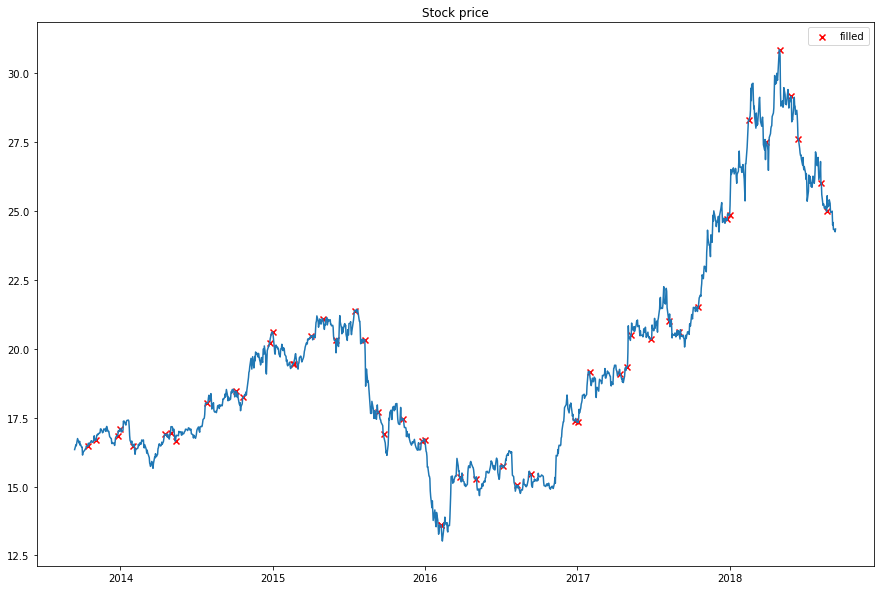

In [19]:
# Plot to see what fillna did:

fig, ax = plt.subplots(figsize=(15, 10))

ax.plot(X_new)
ax.scatter(x=X_new.loc[missing_indices].index,
           y=X_new.loc[missing_indices].values,
           marker='x', color='red', label='filled')
ax.set(title='Stock price')
ax.legend()
plt.show()

In [21]:
# 4. Fix the time index to 'B'
# AR/ARIMA will now work because we have no missing dates.
X_new.index.freq = 'B'
X_new.index

DatetimeIndex(['2013-09-13', '2013-09-16', '2013-09-17', '2013-09-18',
               '2013-09-19', '2013-09-20', '2013-09-23', '2013-09-24',
               '2013-09-25', '2013-09-26',
               ...
               '2018-08-30', '2018-08-31', '2018-09-03', '2018-09-04',
               '2018-09-05', '2018-09-06', '2018-09-07', '2018-09-10',
               '2018-09-11', '2018-09-12'],
              dtype='datetime64[ns]', length=1304, freq='B')

In [36]:
# train test split
from sklearn.model_selection import train_test_split
from statsmodels.tsa.ar_model import AR

# 1. No shuffling (otherwise will lose time sequence)
# 2. No 'y' - you are predicting X[t]
#
# Normally (non-time series):
#   X_train, X_test, y_train, y_test = train_test_split(df) # shuffle=True
#
train, test = train_test_split(X_new, shuffle=False) # shuffle=False!!
print(train.shape)
print(test.shape)

(978, 1)
(326, 1)


In [37]:
# fit AR
ar = AR(train)
model = ar.fit()
print('aic', model.aic, '\nbic', model.bic,
      '\np', model.k_ar, '\nparams', model.params)

aic -3.5331418064263267 
bic -3.4162478900173214 
p 21 
params const        0.060259
L1.Close     1.109076
L2.Close    -0.181418
L3.Close     0.126091
L4.Close    -0.044428
L5.Close    -0.003410
L6.Close    -0.010530
L7.Close     0.005320
L8.Close     0.126986
L9.Close    -0.070748
L10.Close   -0.034551
L11.Close   -0.023872
L12.Close   -0.039058
L13.Close    0.011499
L14.Close    0.024868
L15.Close   -0.006042
L16.Close   -0.072526
L17.Close    0.078135
L18.Close    0.014881
L19.Close   -0.035213
L20.Close   -0.010135
L21.Close    0.031871
dtype: float64


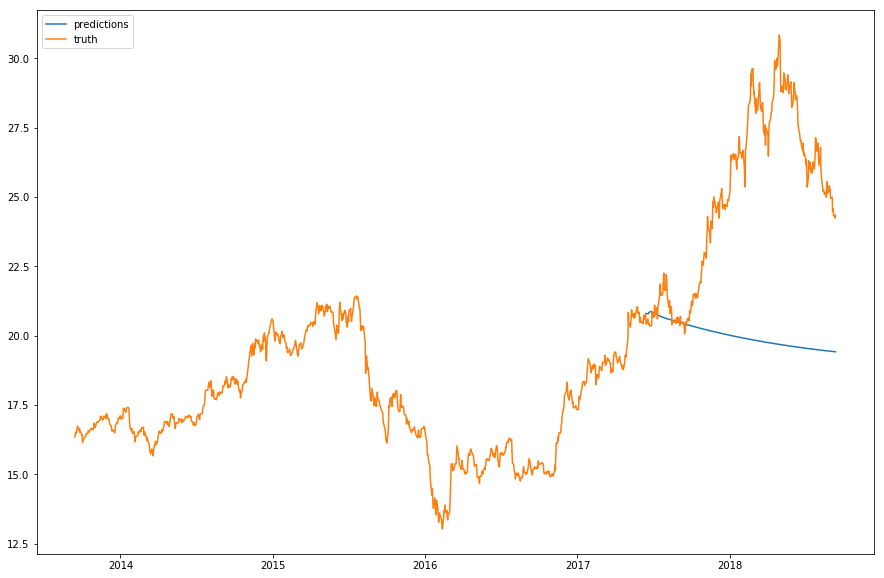

In [38]:
# predict
start = test.index[0]
end = test.index[-1]
predictions = model.predict(start, end)

fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(predictions, label='predictions')
ax.plot(X, label='truth')
ax.legend()

In [39]:
from sklearn.metrics import r2_score, mean_squared_error
print('R2', r2_score(test, predictions.values))
print('MSE', mean_squared_error(test, predictions.values))

R2 -2.9094906816510253
MSE 36.4568091467806


In [40]:
from statsmodels.tsa.stattools import arma_order_select_ic

# Run arma_order_select_ic with train to select best p & q
# fit ARMA
# predict
# metrics

# Auto-regressive + Moving average
ic = arma_order_select_ic(train, max_ar=5, max_ma=5, ic=['bic', 'aic'])

C:\Users\issohl\AppData\Local\Continuum\miniconda3\envs\mldds03\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\Users\issohl\AppData\Local\Continuum\miniconda3\envs\mldds03\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
C:\Users\issohl\AppData\Local\Continuum\miniconda3\envs\mldds03\lib\site-packages\scipy\signal\signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional i

In [41]:
ic # print results

{'bic':              0            1            2            3           4           5
 0  4083.747714  2831.017834  1892.674646  1292.005487  858.635535  603.094186
 1  -660.551929  -668.225636  -664.373766  -658.981316 -653.067566 -646.199188
 2  -666.486293  -664.920187  -656.087661  -651.404411 -646.498320 -635.074564
 3  -663.137682  -658.169414  -653.714716          NaN -632.987025 -627.111913
 4  -659.713895  -655.438905  -653.275586  -642.434995 -626.175689 -619.164856
 5  -653.192098  -648.832579  -642.611103  -640.705775 -637.088691 -628.607411,
 'aic':              0            1            2            3           4           5
 0  4073.976694  2816.361305  1873.132607  1267.577939  829.322477  568.895619
 1  -675.208458  -687.767674  -688.801315  -688.294374 -687.266134 -685.283265
 2  -686.028332  -689.347736  -685.400719  -685.602979 -685.582397 -679.044151
 3  -687.565230  -687.482472  -687.913283          NaN -676.956612 -675.967010
 4  -689.026953  -689.637473  -692.35

In [42]:
# fit using recommended (p, q)'s
from statsmodels.tsa.arima_model import ARMA

# lowest BIC metric (Bayesian Information Criterion)
print(ic.bic_min_order)
arma_bic = ARMA(train, ic.bic_min_order)
arma_bic_model = arma_bic.fit() # wrapper

# X[t] = const + ar.L1.index * X[t-1] + ar.L2.index * X[t-2] + noise[t]
print('aic', arma_bic_model.aic,
      '\nbic', arma_bic_model.bic,
      '\np', arma_bic_model.k_ar,
      '\nq', arma_bic_model.k_ma,
      '\nparams', arma_bic_model.params)

# lowest AIC metric
print(ic.aic_min_order)

arma_aic = ARMA(train, ic.aic_min_order)
arma_aic_model = arma_aic.fit() # wrapper

print('aic', arma_aic_model.aic,
      '\nbic', arma_aic_model.bic,
      '\np', arma_aic_model.k_ar,
      '\nq', arma_aic_model.k_ma,
      '\nparams', arma_aic_model.params)

(1, 1)
aic -687.7676742452909 
bic -668.2256355651516 
p 1 
q 1 
params const          17.885986
ar.L1.Close     0.995602
ma.L1.Close     0.130864
dtype: float64
(4, 2)
aic -692.3596638170679 
bic -653.2755864567894 
p 4 
q 2 
params const          17.876363
ar.L1.Close     1.670033
ar.L2.Close    -1.663996
ar.L3.Close     1.140984
ar.L4.Close    -0.152331
ma.L1.Close    -0.559992
ma.L2.Close     0.907749
dtype: float64


-3.7448092086501186
44.24632716724948
-3.6904502126658008
43.7394182874529


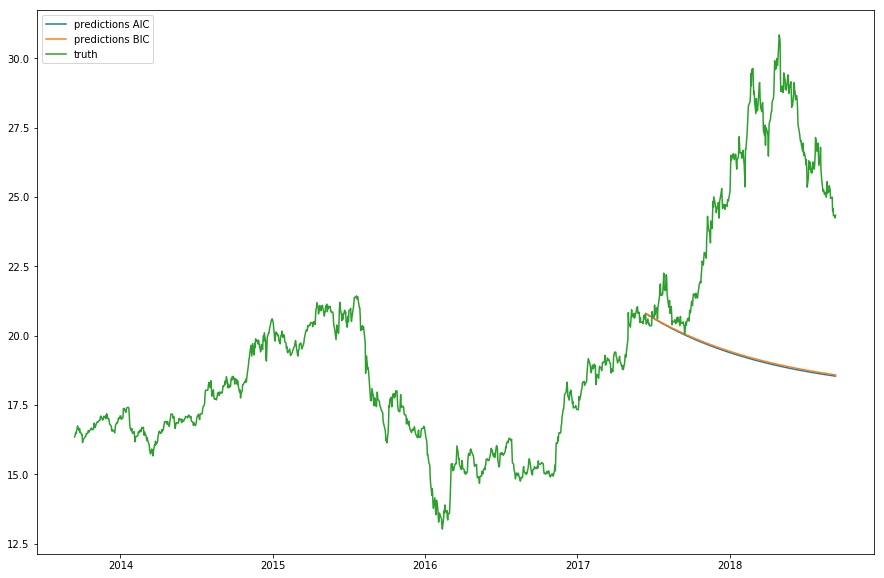

In [43]:
# predict
start = test.index[0]
end = test.index[-1]
predictions_aic = arma_aic_model.predict(start, end)
predictions_bic = arma_bic_model.predict(start, end)

fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(predictions_aic, label='predictions AIC')
ax.plot(predictions_bic, label='predictions BIC')
ax.plot(X, label='truth')
ax.legend()

print(r2_score(test.values, predictions_aic.values))
print(mean_squared_error(test.values, predictions_aic.values))
print(r2_score(test.values, predictions_bic.values))
print(mean_squared_error(test.values, predictions_bic.values))

In [44]:
predictions_aic-predictions_bic # predictions from both ARMA models are quite close

2017-06-14   -0.015982
2017-06-15   -0.027369
2017-06-16   -0.017596
2017-06-19    0.001767
2017-06-20    0.002849
2017-06-21   -0.014677
2017-06-22   -0.025138
2017-06-23   -0.015161
2017-06-26   -0.001248
2017-06-27   -0.003880
2017-06-28   -0.018448
2017-06-29   -0.024038
2017-06-30   -0.014255
2017-07-03   -0.004832
2017-07-04   -0.009532
2017-07-05   -0.021045
2017-07-06   -0.023186
2017-07-07   -0.014403
2017-07-10   -0.008587
2017-07-11   -0.014179
2017-07-12   -0.022843
2017-07-13   -0.022710
2017-07-14   -0.015332
2017-07-17   -0.012266
2017-07-18   -0.017947
2017-07-19   -0.024137
2017-07-20   -0.022645
2017-07-21   -0.016799
2017-07-24   -0.015715
2017-07-25   -0.020984
                ...   
2018-08-02   -0.046038
2018-08-03   -0.045999
2018-08-06   -0.045959
2018-08-07   -0.045919
2018-08-08   -0.045878
2018-08-09   -0.045837
2018-08-10   -0.045796
2018-08-13   -0.045754
2018-08-14   -0.045712
2018-08-15   -0.045669
2018-08-16   -0.045627
2018-08-17   -0.045584
2018-08-20 

# ARIMA

$ARIMA(p, d, q): X'_t = c + \varepsilon_t + \sum_{i=1}^p \varphi_i X'_{t-i} + \sum_{i=1}^q\theta_i\varepsilon_{t-i}$

$X'_t$ = $X_t$, Differentiated $d$ times

Time Series Stationarity
- Makes time series "stationary" so that we can model it better
- Do this by differentiation (taking the gradient)

(analogous to applying non-linear transformation to data)

In [47]:
from statsmodels.tsa.arima_model import ARIMA

# order : iterable
#    The (p,d,q) order of the model for the number of AR parameters,
#    differences, and MA parameters to use.

pdq_aic = None
pdq_bic = None
min_aic = np.inf
min_bic = np.inf

model_aic = None
model_bic = None

ds = [0, 1, 2]
ps = [0, 1, 2, 3]
qs = [0, 1, 2, 3]

for p in ps:
    for q in qs:
        for d in ds:
            try:
                model = ARIMA(train, (p, d, q)).fit()
                print((p, d, q), 'aic', model.aic, 'bic', model.bic)
                
                if model.aic < min_aic:
                    pdq_aic = (p, d, q)
                    min_aic = model.aic
                    model_aic = model

                if model.bic < min_bic:
                    pdq_bic = (p, d, q)
                    min_bic = model.bic
                    model_bic = model
                    
            except:
                print((p, d, q), 'fail, skipping')
                pass
            
print('min aic pdq', pdq_aic)
print('min bic pdq', pdq_bic)

C:\Users\issohl\AppData\Local\Continuum\miniconda3\envs\mldds03\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\Users\issohl\AppData\Local\Continuum\miniconda3\envs\mldds03\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
C:\Users\issohl\AppData\Local\Continuum\miniconda3\envs\mldds03\lib\site-packages\scipy\signal\signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional i

(0, 0, 0) aic 4073.9766942391466 bic 4083.747713579216
(0, 1, 0) aic -680.6235395538426 bic -670.8545662497571
(0, 2, 0) aic -119.05227575148206 bic -109.28535057865588
(0, 0, 1) aic 2816.361305234139 bic 2831.017834244243
(0, 1, 1) aic -692.6112692693182 bic -677.9578093131898
(0, 2, 1) aic -671.8082453685679 bic -657.1578576093286
(0, 0, 2) fail, skipping
(0, 1, 2) aic -693.9426397834418 bic -674.4046931752706
(0, 2, 2) aic -682.7992456036045 bic -663.2653952579522
(0, 0, 3) fail, skipping
(0, 1, 3) aic -693.264811287831 bic -668.8423780276171
(0, 2, 3) fail, skipping
(1, 0, 0) aic -675.2084583748829 bic -660.5519293647784
(1, 1, 0) aic -690.8726267077436 bic -676.2191667516153
(1, 2, 0) aic -295.1847859985437 bic -280.53439823930444
(1, 0, 1) aic -687.7676742452909 bic -668.2256355651516
(1, 1, 1) aic -694.3906529306851 bic -674.8527063225139
(1, 2, 1) aic -681.067891966632 bic -661.5340416209797
(1, 0, 2) aic -688.801314704433 bic -664.3737663542589
(1, 1, 2) fail, skipping


C:\Users\issohl\AppData\Local\Continuum\miniconda3\envs\mldds03\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(1, 2, 2) aic -684.3182859139497 bic -659.9009729818843
(1, 0, 3) aic -688.2943738010458 bic -658.9813157808369
(1, 1, 3) fail, skipping


C:\Users\issohl\AppData\Local\Continuum\miniconda3\envs\mldds03\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(1, 2, 3) aic -682.4678423049681 bic -653.1670667864896
(2, 0, 0) aic -686.0283316951031 bic -666.4862930149638
(2, 1, 0) aic -692.7406423725633 bic -673.2026957643922
(2, 2, 0) aic -439.23401589643527 bic -419.7001655507829
(2, 0, 1) aic -689.3477356262433 bic -664.9201872760692
(2, 1, 1) aic -692.5939565819313 bic -668.1715233217174
(2, 2, 1) aic -683.439028306515 bic -659.0217153744495
(2, 0, 2) fail, skipping
(2, 1, 2) aic -691.8895627596885 bic -662.5826428474318
(2, 2, 2) aic -683.1577475387303 bic -653.8569720202518
(2, 0, 3) fail, skipping
(2, 1, 3) fail, skipping
(2, 2, 3) aic -682.6909767683696 bic -648.506738663478
(3, 0, 0) aic -687.5652304102168 bic -663.1376820600427
(3, 1, 0) aic -693.9101341394971 bic -669.4877008792832
(3, 2, 0) aic -496.428715155444 bic -472.0114022233786
(3, 0, 1) aic -687.4824718901364 bic -658.1694138699274
(3, 1, 1) aic -693.5581617443281 bic -664.2512418320714
(3, 2, 1) aic -684.1754873631571 bic -654.8747118446786
(3, 0, 2) aic -687.913283305063

C:\Users\issohl\AppData\Local\Continuum\miniconda3\envs\mldds03\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(3, 2, 2) aic -682.7518721611095 bic -648.5676340562179
(3, 0, 3) fail, skipping


C:\Users\issohl\AppData\Local\Continuum\miniconda3\envs\mldds03\lib\site-packages\statsmodels\tsa\tsatools.py:650: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\issohl\AppData\Local\Continuum\miniconda3\envs\mldds03\lib\site-packages\statsmodels\tsa\tsatools.py:651: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\issohl\AppData\Local\Continuum\miniconda3\envs\mldds03\lib\site-packages\statsmodels\tsa\tsatools.py:607: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
C:\Users\issohl\AppData\Local\Continuum\miniconda3\envs\mldds03\lib\site-packages\statsmodels\tsa\tsatools.py:609: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()


(3, 1, 3) fail, skipping
(3, 2, 3) aic -687.0972122643129 bic -648.0295115730082
min aic pdq (3, 1, 2)
min bic pdq (0, 1, 1)


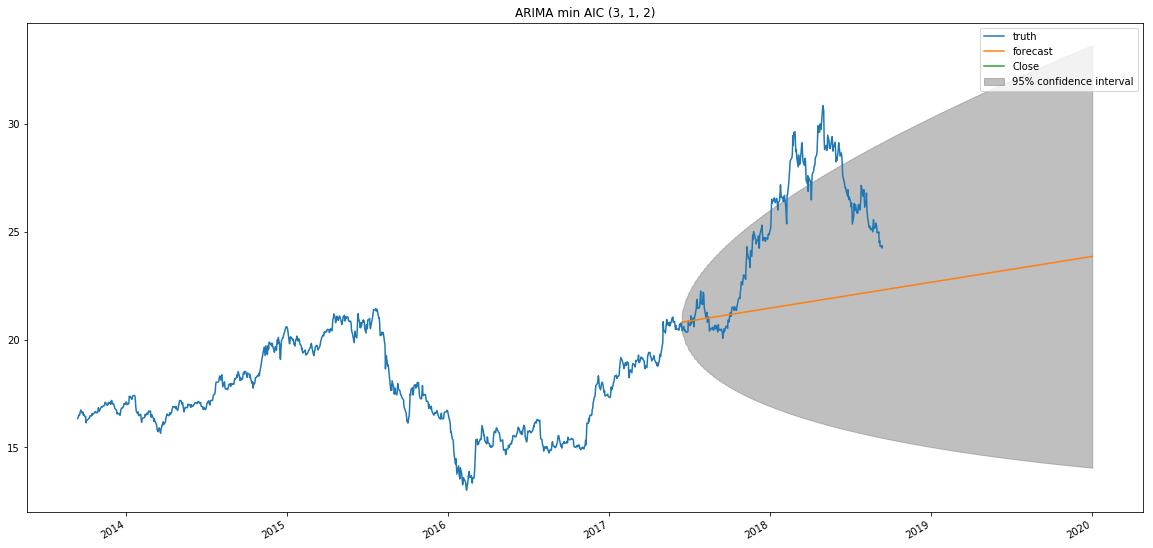

In [48]:
# predict

start = test.index[0]
end = pd.to_datetime('2020-01-01')

fig, ax = plt.subplots(figsize=(20, 10))
ax.set_title('ARIMA min AIC %s' % str(pdq_aic))
ax.plot(df['Close'], label='truth')
model_aic.plot_predict(start, end, ax=ax)
ax.legend()

C:\Users\issohl\AppData\Local\Continuum\miniconda3\envs\mldds03\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]


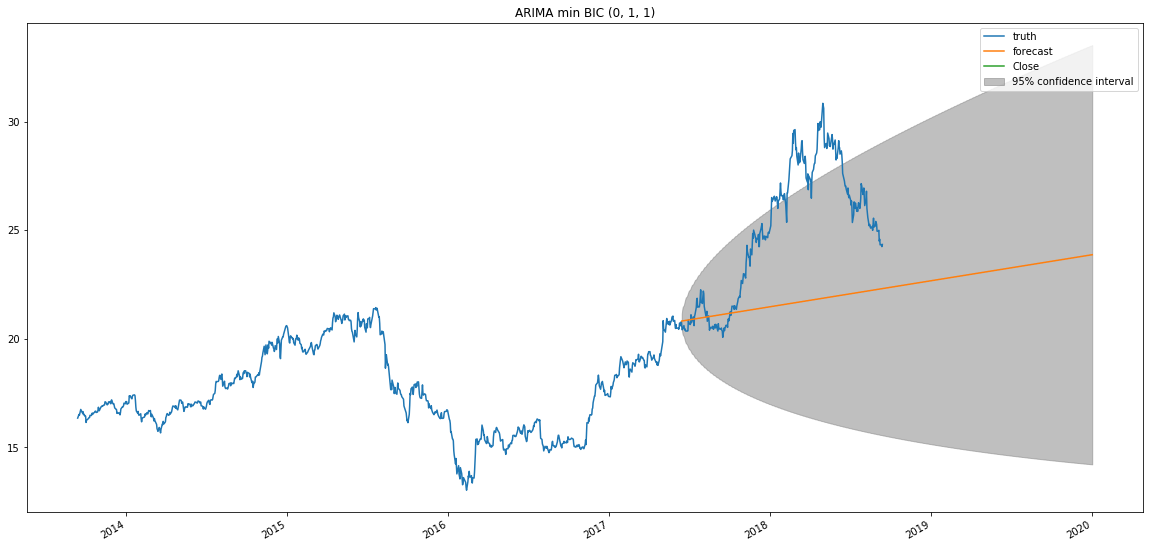

In [49]:
# predict

start = test.index[0]
end = pd.to_datetime('2020-01-01')

fig, ax = plt.subplots(figsize=(20, 10))
ax.set_title('ARIMA min BIC %s' % str(pdq_bic))
ax.plot(df['Close'], label='truth')
model_bic.plot_predict(start, end, ax=ax)
ax.legend()

In [50]:
predictions = model_bic.predict(start, end)

predictions # differences from the last value

2017-06-14    0.031062
2017-06-15    0.004594
2017-06-16    0.004594
2017-06-19    0.004594
2017-06-20    0.004594
2017-06-21    0.004594
2017-06-22    0.004594
2017-06-23    0.004594
2017-06-26    0.004594
2017-06-27    0.004594
2017-06-28    0.004594
2017-06-29    0.004594
2017-06-30    0.004594
2017-07-03    0.004594
2017-07-04    0.004594
2017-07-05    0.004594
2017-07-06    0.004594
2017-07-07    0.004594
2017-07-10    0.004594
2017-07-11    0.004594
2017-07-12    0.004594
2017-07-13    0.004594
2017-07-14    0.004594
2017-07-17    0.004594
2017-07-18    0.004594
2017-07-19    0.004594
2017-07-20    0.004594
2017-07-21    0.004594
2017-07-24    0.004594
2017-07-25    0.004594
                ...   
2019-11-21    0.004594
2019-11-22    0.004594
2019-11-25    0.004594
2019-11-26    0.004594
2019-11-27    0.004594
2019-11-28    0.004594
2019-11-29    0.004594
2019-12-02    0.004594
2019-12-03    0.004594
2019-12-04    0.004594
2019-12-05    0.004594
2019-12-06    0.004594
2019-12-09 

In [51]:
# Unlike AR or ARMA, ARIMA returns differences in predict
# Instead, use forecast()

# Returns:
# forecast (array) – Array of out of sample forecasts
# stderr (array) – Array of the standard error of the forecasts.
# conf_int (array) – 2d array of the confidence interval for the forecast
model_bic.forecast(steps=4)

C:\Users\issohl\AppData\Local\Continuum\miniconda3\envs\mldds03\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]


(array([20.81106262, 20.81565667, 20.82025072, 20.82484478]),
 array([0.16923351, 0.2551248 , 0.31864925, 0.37146471]),
 array([[20.47937104, 21.14275421],
        [20.31562125, 21.31569209],
        [20.19570967, 21.44479178],
        [20.09678733, 21.55290222]]))

C:\Users\issohl\AppData\Local\Continuum\miniconda3\envs\mldds03\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]


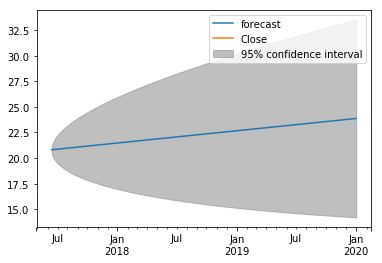

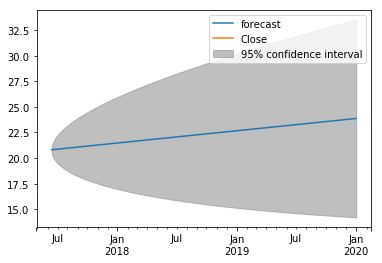

In [52]:
model_bic.plot_predict(start, end)